In [50]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from lib.utils import job_type_label, get_counts, plot_box_by_category, reg_metrics, leadership_label
from lib.utils import heatmap_by_category, alpha2_to_alpha3, features_preprocessing, log_to_mlflow
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import BaggingRegressor
import joblib
import mlflow

In [51]:
cwd = Path.cwd()
source_data = Path(cwd)/"data"
preprocessed_data = cwd/'output/preprocessed_data'
output = Path(cwd)/"output"

# Exploratory Data Analysis

## Quick Look

In [52]:
salaries = pd.read_csv(source_data/"salaries.csv")

In [53]:
salaries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16494 entries, 0 to 16493
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           16494 non-null  int64 
 1   experience_level    16494 non-null  object
 2   employment_type     16494 non-null  object
 3   job_title           16494 non-null  object
 4   salary              16494 non-null  int64 
 5   salary_currency     16494 non-null  object
 6   salary_in_usd       16494 non-null  int64 
 7   employee_residence  16494 non-null  object
 8   remote_ratio        16494 non-null  int64 
 9   company_location    16494 non-null  object
 10  company_size        16494 non-null  object
dtypes: int64(4), object(7)
memory usage: 1.4+ MB


In [54]:
salaries = salaries[['work_year', 'experience_level', 'employment_type', 'job_title', 'salary_currency',
                      'employee_residence', 'remote_ratio', 'company_location', 'company_size',
                      'salary_in_usd']]
salaries

,work_year,experience_level,employment_type,job_title,salary_currency,employee_residence,remote_ratio,company_location,company_size,salary_in_usd
0,2024,MI,FT,Data Scientist,USD,AU,0,AU,S,120000
1,2024,MI,FT,Data Scientist,USD,AU,0,AU,S,70000
2,2024,MI,CT,Data Scientist,USD,US,0,US,M,130000
3,2024,MI,CT,Data Scientist,USD,US,0,US,M,110000
4,2024,MI,FT,Data Science Manager,USD,US,0,US,M,240000
...,...,...,...,...,...,...,...,...,...,...
16489,2020,SE,FT,Data Scientist,USD,US,100,US,L,412000
16490,2021,MI,FT,Principal Data Scientist,USD,US,100,US,L,151000
16491,2020,EN,FT,Data Scientist,USD,US,100,US,S,105000
16492,2020,EN,CT,Business Data Analyst,USD,US,100,US,L,100000


In [55]:
for col in salaries.columns:
    print(f"{col} variable counts:")
    print(len(salaries[col].unique()))

work_year variable counts:
5
experience_level variable counts:
4
employment_type variable counts:
4
job_title variable counts:
155
salary_currency variable counts:
23
employee_residence variable counts:
88
remote_ratio variable counts:
3
company_location variable counts:
77
company_size variable counts:
3
salary_in_usd variable counts:
2931


In [56]:
salaries[["salary_in_usd"]].describe()

,salary_in_usd
count,16494.000000
mean,149713.575725
std,68516.136918
min,15000.000000
25%,101517.500000
50%,141300.000000
75%,185900.000000
max,800000.000000


<Axes: >

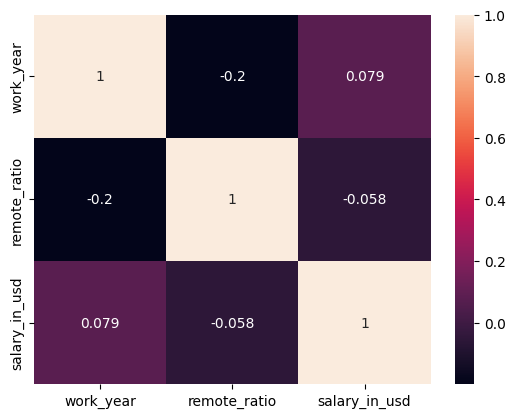

In [57]:
numeric_sal = salaries[['work_year', 'remote_ratio', 'salary_in_usd']]
sns.heatmap(numeric_sal.corr(), annot=True)

In [58]:
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=[
        "Top Job Titles", "Top Employee Residences",
    ]
)
cols = [
    ('job_title', None, 1, 1),
    ('employee_residence', None, 2, 1),
]
for col, order, row, column in cols:
    x, y = get_counts(salaries, col)
    fig.add_trace(go.Bar(x=x, y=y), row=row, col=column)

fig.update_yaxes(title_text="Count", row=1, col=1)
fig.update_yaxes(title_text="Count", row=2, col=1)

fig.update_layout(height=700, width=1000, showlegend=False)
fig.show()

In [59]:
count_jobexp = salaries.groupby(['job_title', 'experience_level']).size().reset_index(name='count')

fig = px.bar(
    count_jobexp,
    x='job_title',
    y='count',
    color='experience_level',
    barmode='stack',
    title='Count of Experience Levels per Job Title'
)
fig.update_layout(height=1000, width=1000, showlegend=True)
fig.show()

In [60]:
job_title_salary = salaries.groupby(['job_title'])['salary_in_usd'].median().reset_index()
job_title_salary = job_title_salary.sort_values('salary_in_usd', ascending=False)
fig = px.bar(job_title_salary, x='job_title', y='salary_in_usd',
             title="Average Salary by Job Title",
             labels={'job_title': 'Job Title', 'salary_in_usd': 'Average Salary (USD)'})
fig.update_layout(height=800, width=1000, showlegend=False)
fig.show()

## Manual Grouping Country and Job Title

In [61]:
salaries2 = salaries.copy()
salaries2['work_year'] = salaries2['work_year'].astype(str)
salaries2['remote_ratio'] = salaries2['remote_ratio'].astype(str)

In [62]:
salaries2['job_type'] = salaries2['job_title'].apply(job_type_label)
print(salaries2['job_type'].unique())

['Data' 'BI' 'ML' 'Others' 'AI' 'Robotics']


In [63]:
country_codes = list(set(salaries['employee_residence'].tolist() + salaries['company_location'].tolist()))
len(country_codes)

90

In [64]:
country_to_continent = {
    'ES': 'Europe', 'SI': 'Europe', 'IQ': 'Asia', 'IL': 'Asia', 'HK': 'Asia',
    'NG': 'Africa', 'LV': 'Europe', 'AS': 'North America', 'BO': 'South America',
    'AE': 'Asia', 'GH': 'Africa', 'QA': 'Asia', 'AU': 'Oceania', 'SE': 'Europe',
    'RS': 'Europe', 'JP': 'Asia', 'DK': 'Europe', 'IT': 'Europe', 'PR': 'North America',
    'AM': 'Asia', 'TH': 'Asia', 'NL': 'Europe', 'PE': 'South America', 'BG': 'Europe',
    'HN': 'North America', 'NO': 'Europe', 'MX': 'North America', 'KW': 'Asia',
    'VN': 'Asia', 'SA': 'Asia', 'GI': 'Europe', 'PK': 'Asia', 'BR': 'South America',
    'AD': 'Europe', 'BA': 'Europe', 'UG': 'Africa', 'LB': 'Asia', 'LU': 'Europe',
    'GR': 'Europe', 'BS': 'North America', 'EC': 'South America', 'IN': 'Asia',
    'CN': 'Asia', 'CL': 'South America', 'DZ': 'Africa', 'RU': 'Europe', 'HU': 'Europe',
    'FR': 'Europe', 'UZ': 'Asia', 'EE': 'Europe', 'IR': 'Asia', 'AT': 'Europe',
    'ID': 'Asia', 'AR': 'South America', 'SG': 'Asia', 'DO': 'North America',
    'GB': 'Europe', 'CR': 'North America', 'UA': 'Europe', 'PH': 'Asia', 'BE': 'Europe',
    'LT': 'Europe', 'NZ': 'Oceania', 'EG': 'Africa', 'CA': 'North America', 'IE': 'Europe',
    'OM': 'Asia', 'MY': 'Asia', 'KR': 'Asia', 'KE': 'Africa', 'TR': 'Asia',
    'GE': 'Asia', 'DE': 'Europe', 'CY': 'Europe', 'ZA': 'Africa', 'CH': 'Europe',
    'MT': 'Europe', 'MD': 'Europe', 'MU': 'Africa', 'US': 'North America',
    'HR': 'Europe', 'FI': 'Europe', 'CF': 'Africa', 'RO': 'Europe', 'CO': 'South America',
    'TN': 'Africa', 'JE': 'Europe', 'PL': 'Europe', 'CZ': 'Europe', 'PT': 'Europe'
}
salaries2['employee_continent'] = salaries2['employee_residence'].map(country_to_continent)
salaries2['company_continent'] = salaries2['company_location'].map(country_to_continent)

In [65]:
job_type_order = ['Data', 'BI', 'ML', 'AI', 'Robotics', 'Others']
work_year_order = ['2020', '2021', '2022', '2023', '2024']
remote_ratio_order = ['0', '50', '100']
experience_level_order = ['EN', 'MI', 'SE', 'EX']
company_size_order = ['S', 'M', 'L']

fig = make_subplots(
    rows=4, cols=2,
    subplot_titles=[
        "Experience Level", "Employment Type",
        "Job Type", "Employee Continent",
        "Company Continent", "Company Size",
        "Work Year", "Remote Ratio"
    ]
)
cols = [
    ('experience_level', experience_level_order, 1, 1),
    ('employment_type', None, 1, 2),
    ('job_type', job_type_order, 2, 1),
    ('employee_continent', None, 2, 2),
    ('company_continent', None, 3, 1),
    ('company_size', company_size_order, 3, 2),
    ('work_year', work_year_order, 4, 1),
    ('remote_ratio', remote_ratio_order, 4, 2)
]
for col, order, row, column in cols:
    x, y = get_counts(salaries2, col, order)
    fig.add_trace(go.Bar(x=x, y=y), row=row, col=column)

fig.update_layout(height=700, width=1000, showlegend=False, title_text="Categorical Value Counts by Features")
fig.show()


In [66]:
fig = px.histogram(salaries2, x='salary_in_usd', nbins=30, title='Salary Distribution (USD)')
fig.show()

In [67]:
job_type_colors = {
    'Data': 'indianred',
    'ML': 'lightseagreen',
    'AI': '#8da0cb',
    'BI': '#e78ac3',
    'Robotics': '#a6d854',
    'Others': '#ffd92f'
}

experience_colors = {
    'EN': '#636EFA',
    'MI': '#EF553B',
    'SE': '#00CC96',
    'EX': '#AB63FA'
}

company_size_colors = {
    'S': '#ffd92f',
    'M': '#e78ac3',
    'L': '#a6d854',
}

company_location_colors = {
    'North America': '#5DADE2',
    'Europe': '#F39C12',
    'Asia': '#27AE60',
    'Oceania': '#AF7AC5',
    'Africa': '#D35400',
    'South America': '#566573'
}

remote_ratio_colors = {
    '0': '#27AE60',
    '50': '#5DADE2',
    '100': '#ffd92f',
}

work_year_colors = {
    '2020': '#566573',
    '2021': '#F39C12',
    '2022': '#00CC96',
    '2023': "#030303",
    '2024': '#EF553B',

}

In [68]:
fig = make_subplots(
    rows=3, cols=2,
    subplot_titles=["Salary by Job Type", "Salary by Experience Level",
                    "Salary by Company Size", "Salary by Company Continent",
                    "Salary by Remote Ratio", "Salary by Work Year"]
)

# Add job_type boxplots to first column, experience_level boxplots to second
plot_box_by_category(fig, salaries2, 'job_type', 'salary_in_usd', job_type_colors, 1, 1)
plot_box_by_category(fig, salaries2, 'experience_level', 'salary_in_usd', experience_colors, 1, 2)
plot_box_by_category(fig, salaries2, 'company_size', 'salary_in_usd', company_size_colors, 2, 1)
plot_box_by_category(fig, salaries2, 'company_continent', 'salary_in_usd', company_location_colors, 2, 2)
plot_box_by_category(fig, salaries2, 'remote_ratio', 'salary_in_usd', remote_ratio_colors, 3, 1)
plot_box_by_category(fig, salaries2, 'work_year', 'salary_in_usd', work_year_colors, 3, 2)

fig.update_layout(
    height=1000,
    width=1000,
    showlegend=False,
    title_text="Salaries Distribution by Category"
)
fig.show()

In [69]:
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=["Median Salaries by Job Experience and Remote Work",
                    "Median Salaries by Employee Continent and Job Type"]
)

trace1 = heatmap_by_category(salaries2, 'experience_level', 'remote_ratio', 'salary_in_usd',
                             'Viridis', 'Median Salary [USD]',
                             1, 0.82, remote_ratio_order, experience_level_order)

fig.add_trace(trace1, row=1, col=1)

trace2 = heatmap_by_category(salaries2, 'employee_continent', 'job_type', 'salary_in_usd',
                             'Magma', 'Median Salary [USD]',
                             1, 0.19, job_type_order)

fig.add_trace(trace2, row=2, col=1)

fig.update_layout(
    height=800,
    width=800,
    showlegend=False,
    title_text="Median Salaries Heatmap by Categories"
)
fig.show()

In [70]:
# Aggregate median salary by year and job_type
med_salary_by_jobtype_year = salaries2.groupby(['work_year', 'job_type'])['salary_in_usd'].median().reset_index()
med_salary_by_exp_year = salaries2.groupby(['work_year', 'experience_level'])['salary_in_usd'].median().reset_index()

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=[
        "Median Salaries by Job Type over the Years",
        "Median Salaries by Job Experience over the Years"
    ]
)

# First subplot: Job Type
for jt in med_salary_by_jobtype_year['job_type'].unique():
    df_jt = med_salary_by_jobtype_year[med_salary_by_jobtype_year['job_type'] == jt]
    fig.add_trace(go.Scatter(
        x=df_jt['work_year'],
        y=df_jt['salary_in_usd'],
        mode='lines+markers',
        name=jt,
        showlegend=True
    ), row=1, col=1)

# Second subplot: Experience Level
for exp in med_salary_by_exp_year['experience_level'].unique():
    df_exp = med_salary_by_exp_year[med_salary_by_exp_year['experience_level'] == exp]
    fig.add_trace(go.Scatter(
        x=df_exp['work_year'],
        y=df_exp['salary_in_usd'],
        mode='lines+markers',
        name=exp,
        showlegend=True
    ), row=1, col=2)

fig.update_layout(
    height=500,
    width=1300,
    legend_title="Category",
    title_text="Median Salaries by Job Type and Experience Level over the Years"
)
fig.show()


## Outliers

In [71]:
# Programmatic Outlier Detection using IQR method
Q1 = salaries2['salary_in_usd'].quantile(0.25)
Q3 = salaries2['salary_in_usd'].quantile(0.75)
IQR = Q3 - Q1

# Calculate bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"IQR Analysis:")
print(f"Q1 (25th percentile): ${Q1:,.2f}")
print(f"Q3 (75th percentile): ${Q3:,.2f}")
print(f"IQR: ${IQR:,.2f}")
print(f"Lower bound: ${lower_bound:,.2f}")
print(f"Upper bound: ${upper_bound:,.2f}")

# Identify outliers
outliers = salaries2[(salaries2['salary_in_usd'] < lower_bound) | (salaries2['salary_in_usd'] > upper_bound)]

# Quantify outliers
total_records = len(salaries2)
outlier_count = len(outliers)
outlier_percentage = (outlier_count / total_records) * 100

print(f"\n=== Outlier Quantification ===")
print(f"Total records: {total_records:,}")
print(f"Outlier records: {outlier_count:,}")
print(f"Outlier percentage: {outlier_percentage:.2f}%")

IQR Analysis:
Q1 (25th percentile): $101,517.50
Q3 (75th percentile): $185,900.00
IQR: $84,382.50
Lower bound: $-25,056.25
Upper bound: $312,473.75

=== Outlier Quantification ===
Total records: 16,494
Outlier records: 284
Outlier percentage: 1.72%


In [72]:
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=[
        "Outlier Jobs by Experience Level", "Outlier Jobs by Job Title",
    ]
)
cols = [
    ('experience_level', None, 1, 1),
    ('job_title', None, 2, 1),
]
for col, order, row, column in cols:
    x, y = get_counts(outliers, col)
    fig.add_trace(go.Bar(x=x, y=y), row=row, col=column)

fig.update_yaxes(title_text="Count", row=1, col=1)
fig.update_yaxes(title_text="Count", row=2, col=1)

fig.update_layout(height=700, width=1000, showlegend=False)
fig.show()

# Features Importance and Features Engineering

## Existing Features

In [73]:
salaries2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16494 entries, 0 to 16493
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           16494 non-null  object
 1   experience_level    16494 non-null  object
 2   employment_type     16494 non-null  object
 3   job_title           16494 non-null  object
 4   salary_currency     16494 non-null  object
 5   employee_residence  16494 non-null  object
 6   remote_ratio        16494 non-null  object
 7   company_location    16494 non-null  object
 8   company_size        16494 non-null  object
 9   salary_in_usd       16494 non-null  int64 
 10  job_type            16494 non-null  object
 11  employee_continent  16494 non-null  object
 12  company_continent   16494 non-null  object
dtypes: int64(1), object(12)
memory usage: 1.6+ MB


In [74]:
salaries3 = salaries2.drop(['job_title', 'employee_residence', 'company_location'], axis=1)
salaries3 = salaries3[['experience_level', 'company_size', 'work_year', 'remote_ratio', 'salary_currency',
                       'employment_type', 'job_type', 'employee_continent', 'company_continent',
                       'salary_in_usd']]
salaries3

,experience_level,company_size,work_year,remote_ratio,salary_currency,employment_type,job_type,employee_continent,company_continent,salary_in_usd
0,MI,S,2024,0,USD,FT,Data,Oceania,Oceania,120000
1,MI,S,2024,0,USD,FT,Data,Oceania,Oceania,70000
2,MI,M,2024,0,USD,CT,Data,North America,North America,130000
3,MI,M,2024,0,USD,CT,Data,North America,North America,110000
4,MI,M,2024,0,USD,FT,Data,North America,North America,240000
...,...,...,...,...,...,...,...,...,...,...
16489,SE,L,2020,100,USD,FT,Data,North America,North America,412000
16490,MI,L,2021,100,USD,FT,Data,North America,North America,151000
16491,EN,S,2020,100,USD,FT,Data,North America,North America,105000
16492,EN,L,2020,100,USD,CT,Data,North America,North America,100000


In [75]:
rf_reg = RandomForestRegressor(n_estimators=200, max_depth=8)
ordinal_cols = [0,1,2,3]
nominal_cols = [4,5,6,7,8]
ct, sc, X_train, X_test, y_train, y_test = features_preprocessing(salaries3, ordinal_cols, nominal_cols,
                                                              stratify_col='employee_continent')
r2, rmse, mse, mae, mse_usd, rmse_usd, mae_usd, importances_series = reg_metrics(salaries3, rf_reg, ct, X_train, y_train, X_test, y_test,
                                                                                 usd_scale_back=False)

R^2 Score: 0.310
RMSE: 53,616.64
MSE: 2,874,743,994.35
MAE: 40,548.30
ord__experience_level                    2.914341e-01
nom__salary_currency_USD                 2.193106e-01
nom__job_type_Data                       1.385785e-01
nom__employee_continent_North America    1.315343e-01
nom__job_type_BI                         7.923322e-02
ord__work_year                           2.906508e-02
ord__remote_ratio                        2.182541e-02
nom__job_type_ML                         1.624233e-02
ord__company_size                        1.239494e-02
nom__job_type_Others                     1.186265e-02
nom__salary_currency_ILS                 5.086234e-03
nom__employee_continent_South America    4.206603e-03
nom__job_type_AI                         4.070654e-03
nom__employee_continent_Asia             3.551672e-03
nom__employment_type_FT                  3.352883e-03
nom__salary_currency_GBP                 2.990062e-03
nom__employment_type_CT                  2.724224e-03
nom__salary_

In [76]:
# mlflow.set_experiment("salary_prediction")
# log_to_mlflow(rf_reg, 'with_existing_features', 'random_forest', r2, rmse, mse, mae)

## New Features

### Features Interaction

In [77]:
salaries4 = salaries3.copy()
salaries4['job_level'] = salaries2['job_title'].apply(leadership_label)
salaries4['exp_level_job'] = salaries4['experience_level'] + '_' + salaries4['job_type']
salaries4['exp_level_econtinent'] = salaries4['experience_level'] + '_' + salaries4['employee_continent']
salaries4['job_level_exp'] = salaries4['job_level'] + '_' + salaries4['experience_level']
salaries4['work_year_econtinent'] = salaries4['work_year'] + '_' + salaries4['employee_continent']
salaries4['same_continent'] = (salaries4['employee_continent'] == salaries4['company_continent']).astype(int)
job_title_freq = salaries2['job_title'].value_counts().to_dict()
salaries4['job_title_popularity'] = salaries2['job_title'].map(job_title_freq)
salaries4['log_salaries'] = np.log1p(salaries4['salary_in_usd'])
salaries4 = salaries4.drop(['salary_in_usd'], axis=1)
salaries4

,experience_level,company_size,work_year,remote_ratio,salary_currency,employment_type,job_type,employee_continent,company_continent,job_level,exp_level_job,exp_level_econtinent,job_level_exp,work_year_econtinent,same_continent,job_title_popularity,log_salaries
0,MI,S,2024,0,USD,FT,Data,Oceania,Oceania,Staff,MI_Data,MI_Oceania,Staff_MI,2024_Oceania,1,3312,11.695255
1,MI,S,2024,0,USD,FT,Data,Oceania,Oceania,Staff,MI_Data,MI_Oceania,Staff_MI,2024_Oceania,1,3312,11.156265
2,MI,M,2024,0,USD,CT,Data,North America,North America,Staff,MI_Data,MI_North America,Staff_MI,2024_North America,1,3312,11.775297
3,MI,M,2024,0,USD,CT,Data,North America,North America,Staff,MI_Data,MI_North America,Staff_MI,2024_North America,1,3312,11.608245
4,MI,M,2024,0,USD,FT,Data,North America,North America,Manager,MI_Data,MI_North America,Manager_MI,2024_North America,1,122,12.388398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16489,SE,L,2020,100,USD,FT,Data,North America,North America,Staff,SE_Data,SE_North America,Staff_SE,2020_North America,1,3312,12.928781
16490,MI,L,2021,100,USD,FT,Data,North America,North America,Staff,MI_Data,MI_North America,Staff_MI,2021_North America,1,10,11.925042
16491,EN,S,2020,100,USD,FT,Data,North America,North America,Staff,EN_Data,EN_North America,Staff_EN,2020_North America,1,3312,11.561725
16492,EN,L,2020,100,USD,CT,Data,North America,North America,Staff,EN_Data,EN_North America,Staff_EN,2020_North America,1,21,11.512935


In [78]:
fig = px.histogram(salaries4, x='log_salaries', nbins=30, title='Log Salary Distribution')
fig.show()

In [79]:
ordinal_cols = [0,1,2,3]
nominal_cols = [4,5,6,7,8,9,10,11,12,13,14]
ct, sc, X_train, X_test, y_train, y_test = features_preprocessing(salaries4, ordinal_cols, nominal_cols,
                                                              stratify_col='employee_continent')
r2, rmse, mse, mae, mse_usd, rmse_usd, mae_usd, importances_series = reg_metrics(salaries4, rf_reg, ct, X_train, y_train, X_test, y_test)

R^2 Score: 0.484
RMSE: 0.34
MSE: 0.12
MAE: 0.27
RMSE in usd: 52,170.06
MSE in usd: 2,721,715,605.98
MAE in usd: 38,179.38
nom__employee_continent_North America     0.336210
remainder__job_title_popularity           0.100380
nom__salary_currency_USD                  0.087405
ord__experience_level                     0.076197
nom__exp_level_job_MI_Data                0.056095
                                            ...   
nom__salary_currency_CLP                  0.000000
nom__exp_level_job_MI_Robotics            0.000000
nom__job_level_exp_Head_MI                0.000000
nom__work_year_econtinent_2020_Oceania    0.000000
nom__salary_currency_NZD                  0.000000
Length: 140, dtype: float64


In [80]:
# log_to_mlflow(rf_reg, 'with_existing_features_and_log_target', 'random_forest', r2, rmse, mse, mae)

### New Grouping based on Employee Residence and Job Title Using KNN

In [81]:
from sklearn.cluster import KMeans

X_kmeans = salaries2[['employee_residence', 'job_title']]
y_kmeans = salaries4['log_salaries']
ct = ColumnTransformer(transformers=[('nom', OneHotEncoder(sparse_output=False), [0,1])],
                                     remainder="passthrough")
X_kmeans = ct.fit_transform(X_kmeans)
n_groups = 10
kmeans = KMeans(n_clusters=n_groups, random_state=42, n_init=10)
group_labels = kmeans.fit_predict(X_kmeans)
salaries5 = salaries4.copy()
salaries5['kmeans_group'] = group_labels.astype(str)
salaries5['employee_residence'] = salaries2['employee_residence']

In [82]:
salaries5['iso_alpha'] = salaries5['employee_residence'].apply(alpha2_to_alpha3)
fig_geo = px.choropleth(
    salaries5, locations="iso_alpha",
    color="employee_continent",
    title="Countries Grouped by Continent"
)
fig_geo.show()

In [83]:
fig_kmeans = px.choropleth(
    salaries5, locations="iso_alpha",
    color="kmeans_group",
    title="Countries Grouped by KMeans Clusters"
)
fig_kmeans.show()

### Combining with GDP

In [84]:
gdp = pd.read_csv(source_data/'gdp.csv', skiprows=4, skip_blank_lines=True)
gdp = gdp.iloc[:, :-1]
gdp.dropna()
gdp = gdp.drop(['Indicator Name', 'Indicator Code'], axis=1)
gdp = pd.melt(
    gdp,
    id_vars=["Country Name", "Country Code"],     # columns to keep fixed
    var_name="Year",              # new column for former wide column names
    value_name="GDP_USD"          # new column for values
)

In [85]:
gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17290 entries, 0 to 17289
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Name  17290 non-null  object 
 1   Country Code  17290 non-null  object 
 2   Year          17290 non-null  object 
 3   GDP_USD       14541 non-null  float64
dtypes: float64(1), object(3)
memory usage: 540.4+ KB


In [86]:
years_to_keep = ['2020', '2021', '2022', '2023', '2024']

gdp = gdp[gdp['Year'].isin(years_to_keep)]
gdp

,Country Name,Country Code,Year,GDP_USD
15960,Aruba,ABW,2020,2.481857e+09
15961,Africa Eastern and Southern,AFE,2020,9.334072e+11
15962,Afghanistan,AFG,2020,1.995593e+10
15963,Africa Western and Central,AFW,2020,7.972952e+11
15964,Angola,AGO,2020,4.850156e+10
...,...,...,...,...
17285,Kosovo,XKX,2024,1.114860e+10
17286,"Yemen, Rep.",YEM,2024,NaN
17287,South Africa,ZAF,2024,4.002607e+11
17288,Zambia,ZMB,2024,2.632578e+10


In [87]:
salaries6 = pd.merge(
    salaries5,
    gdp[['Country Code', 'Year', 'GDP_USD']],
    how='left',
    left_on=['iso_alpha', 'work_year'],
    right_on=['Country Code', 'Year']
)
salaries6

,experience_level,company_size,work_year,remote_ratio,salary_currency,employment_type,job_type,employee_continent,company_continent,job_level,...,work_year_econtinent,same_continent,job_title_popularity,log_salaries,kmeans_group,employee_residence,iso_alpha,Country Code,Year,GDP_USD
0,MI,S,2024,0,USD,FT,Data,Oceania,Oceania,Staff,...,2024_Oceania,1,3312,11.695255,3,AU,AUS,AUS,2024,1.752193e+12
1,MI,S,2024,0,USD,FT,Data,Oceania,Oceania,Staff,...,2024_Oceania,1,3312,11.156265,3,AU,AUS,AUS,2024,1.752193e+12
2,MI,M,2024,0,USD,CT,Data,North America,North America,Staff,...,2024_North America,1,3312,11.775297,3,US,USA,USA,2024,2.918489e+13
3,MI,M,2024,0,USD,CT,Data,North America,North America,Staff,...,2024_North America,1,3312,11.608245,3,US,USA,USA,2024,2.918489e+13
4,MI,M,2024,0,USD,FT,Data,North America,North America,Manager,...,2024_North America,1,122,12.388398,8,US,USA,USA,2024,2.918489e+13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16489,SE,L,2020,100,USD,FT,Data,North America,North America,Staff,...,2020_North America,1,3312,12.928781,3,US,USA,USA,2020,2.135410e+13
16490,MI,L,2021,100,USD,FT,Data,North America,North America,Staff,...,2021_North America,1,10,11.925042,8,US,USA,USA,2021,2.368117e+13
16491,EN,S,2020,100,USD,FT,Data,North America,North America,Staff,...,2020_North America,1,3312,11.561725,3,US,USA,USA,2020,2.135410e+13
16492,EN,L,2020,100,USD,CT,Data,North America,North America,Staff,...,2020_North America,1,21,11.512935,8,US,USA,USA,2020,2.135410e+13


In [88]:
missing_gdp = salaries6[salaries6['GDP_USD'].isna()]
print(missing_gdp[['work_year','iso_alpha','Year','GDP_USD']].head())

      work_year iso_alpha  Year  GDP_USD
5518       2024       LBN  2024      NaN
5519       2024       LBN  2024      NaN
16369      2021       JEY   NaN      NaN


In [89]:
salaries6.loc[[5518, 5519], 'GDP_USD'] = 28280000000
salaries6.loc[16369, 'GDP_USD'] = 7013000000
missing_gdp = salaries6[salaries6['GDP_USD'].isna()]
print(missing_gdp[['work_year','iso_alpha','Year','GDP_USD']].head())

Empty DataFrame
Columns: [work_year, iso_alpha, Year, GDP_USD]
Index: []


In [90]:
salaries7 = salaries6.drop(['employee_residence', 'iso_alpha', 'Country Code', 'Year'], axis=1)
salaries7 = salaries7[['experience_level', 'company_size', 'work_year', 'remote_ratio',
       'salary_currency', 'employment_type', 'job_type', 'employee_continent',
       'company_continent', 'job_level', 'exp_level_job',
       'exp_level_econtinent', 'job_level_exp', 'work_year_econtinent', 'kmeans_group', 'same_continent',
       'job_title_popularity', 'GDP_USD', 'log_salaries'
       ]]
salaries7

,experience_level,company_size,work_year,remote_ratio,salary_currency,employment_type,job_type,employee_continent,company_continent,job_level,exp_level_job,exp_level_econtinent,job_level_exp,work_year_econtinent,kmeans_group,same_continent,job_title_popularity,GDP_USD,log_salaries
0,MI,S,2024,0,USD,FT,Data,Oceania,Oceania,Staff,MI_Data,MI_Oceania,Staff_MI,2024_Oceania,3,1,3312,1.752193e+12,11.695255
1,MI,S,2024,0,USD,FT,Data,Oceania,Oceania,Staff,MI_Data,MI_Oceania,Staff_MI,2024_Oceania,3,1,3312,1.752193e+12,11.156265
2,MI,M,2024,0,USD,CT,Data,North America,North America,Staff,MI_Data,MI_North America,Staff_MI,2024_North America,3,1,3312,2.918489e+13,11.775297
3,MI,M,2024,0,USD,CT,Data,North America,North America,Staff,MI_Data,MI_North America,Staff_MI,2024_North America,3,1,3312,2.918489e+13,11.608245
4,MI,M,2024,0,USD,FT,Data,North America,North America,Manager,MI_Data,MI_North America,Manager_MI,2024_North America,8,1,122,2.918489e+13,12.388398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16489,SE,L,2020,100,USD,FT,Data,North America,North America,Staff,SE_Data,SE_North America,Staff_SE,2020_North America,3,1,3312,2.135410e+13,12.928781
16490,MI,L,2021,100,USD,FT,Data,North America,North America,Staff,MI_Data,MI_North America,Staff_MI,2021_North America,8,1,10,2.368117e+13,11.925042
16491,EN,S,2020,100,USD,FT,Data,North America,North America,Staff,EN_Data,EN_North America,Staff_EN,2020_North America,3,1,3312,2.135410e+13,11.561725
16492,EN,L,2020,100,USD,CT,Data,North America,North America,Staff,EN_Data,EN_North America,Staff_EN,2020_North America,8,1,21,2.135410e+13,11.512935


In [91]:
salaries7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16494 entries, 0 to 16493
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   experience_level      16494 non-null  object 
 1   company_size          16494 non-null  object 
 2   work_year             16494 non-null  object 
 3   remote_ratio          16494 non-null  object 
 4   salary_currency       16494 non-null  object 
 5   employment_type       16494 non-null  object 
 6   job_type              16494 non-null  object 
 7   employee_continent    16494 non-null  object 
 8   company_continent     16494 non-null  object 
 9   job_level             16494 non-null  object 
 10  exp_level_job         16494 non-null  object 
 11  exp_level_econtinent  16494 non-null  object 
 12  job_level_exp         16494 non-null  object 
 13  work_year_econtinent  16494 non-null  object 
 14  kmeans_group          16494 non-null  object 
 15  same_continent     

In [92]:
ordinal_cols = [0,1,2,3]
nominal_cols = [4,5,6,7,8,9,10,11,12,13,14,15]
ct, sc, X_train, X_test, y_train, y_test = features_preprocessing(salaries7, ordinal_cols, nominal_cols,
                                                              stratify_col='employee_continent')
r2, rmse, mse, mae, mse_usd, rmse_usd, mae_usd, importances_series_final_features, fitted_rf = reg_metrics(
    salaries7, rf_reg, ct, X_train, y_train, X_test, y_test, get_model=True)

R^2 Score: 0.479
RMSE: 0.34
MSE: 0.12
MAE: 0.27
RMSE in usd: 52,412.59
MSE in usd: 2,747,079,837.17
MAE in usd: 38,332.39
nom__employee_continent_North America    0.353583
nom__kmeans_group_4                      0.122022
nom__salary_currency_USD                 0.067622
ord__experience_level                    0.066534
remainder__GDP_USD                       0.043898
                                           ...   
nom__salary_currency_NZD                 0.000000
nom__salary_currency_CLP                 0.000000
nom__exp_level_job_MI_Robotics           0.000000
nom__salary_currency_NOK                 0.000000
nom__salary_currency_ZAR                 0.000000
Length: 151, dtype: float64


In [93]:
base_reg = XGBRegressor()
bag_reg = BaggingRegressor(
    estimator=base_reg,
    n_estimators=200,
    random_state=42,
    bootstrap=True,
    n_jobs=-1
)
r2, rmse, mse, mae, mse_usd, rmse_usd, mae_usd, importances_series = reg_metrics(salaries7, bag_reg, ct, X_train, y_train, X_test, y_test, feature_importance=False)

R^2 Score: 0.501
RMSE: 0.33
MSE: 0.11
MAE: 0.26
RMSE in usd: 51,771.27
MSE in usd: 2,680,264,159.26
MAE in usd: 38,151.27


In [94]:
# log_to_mlflow(bag_reg, 'with_new_features_and_log_target', 'bagging_xgb', r2, rmse, mse, mae)

# Save Data and Make Data Reference for Streamlit App

In [95]:
st_reference = pd.DataFrame()
st_reference['employee_residence'] = salaries2['employee_residence']
st_reference['job_title'] = salaries2['job_title']
st_reference['job_title_popularity'] = salaries7['job_title_popularity']
st_reference['kmeans_group'] = salaries7['kmeans_group']
st_reference['GDP_USD'] = salaries7['GDP_USD']
st_reference = st_reference.drop_duplicates()
st_reference

,employee_residence,job_title,job_title_popularity,kmeans_group,GDP_USD
0,AU,Data Scientist,3312,3,1.752193e+12
2,US,Data Scientist,3312,3,2.918489e+13
4,US,Data Science Manager,122,8,2.918489e+13
6,US,Business Intelligence Engineer,248,8,2.918489e+13
8,GB,Data Architect,433,6,3.643834e+12
...,...,...,...,...,...
16484,JP,Director of Data Science,33,9,5.039148e+12
16485,SG,Data Scientist,3312,3,4.365914e+11
16486,US,Applied Machine Learning Scientist,14,8,2.368117e+13
16487,MT,Data Engineer,3456,2,1.972356e+10


In [99]:
job_titles = salaries['job_title'].unique()
salary_currency = salaries['salary_currency'].unique()
employee_residence = salaries['employee_residence'].unique()
company_location = salaries['company_location'].unique()
salary_in_usd = salaries['salary_in_usd']

In [98]:
salaries7.to_parquet(preprocessed_data/'preprocessed_data.parquet', index=False)
importances_series_final_features.to_csv(preprocessed_data/'final_features.csv', index=True)
st_reference.to_csv(preprocessed_data/'st_reference.csv', index=False)

np.save(preprocessed_data/'job_titles.npy', job_titles)
np.save(preprocessed_data/'salary_currency.npy', salary_currency)
np.save(preprocessed_data/'employee_residence.npy', employee_residence)
np.save(preprocessed_data/'company_location.npy', company_location)
np.save(preprocessed_data/'salary_in_usd.npy', salary_in_usd)

np.save(preprocessed_data/'preprocessed_X_train.npy', X_train)
np.save(preprocessed_data/'preprocessed_y_train.npy', y_train)
np.save(preprocessed_data/'preprocessed_X_test.npy', X_test)
np.save(preprocessed_data/'preprocessed_y_test.npy', y_test)

joblib.dump(fitted_rf, output/"models/random_forest_regressor.joblib")
joblib.dump(bag_reg, output/"models/bagging_regressor.joblib")
joblib.dump(ct, output/'models/column_transformer.joblib')
joblib.dump(sc, output/'models/scaler.joblib')

['/home/hien/Work/AI/SDS-CP032-mlpaygrade/submissions/team-members/hien-nguyen/output/models/scaler.joblib']